# 4.1 - Amortized inference on a simplified gravitational wave model from astrophysics

In this notebook we demonstrate an application of Neural Posterior Estimation with a Custom Embedding Net to perform amortized inference on a simplified gravitational wave simulator. We will also highlight some methods for validating the inferred posteriors using simulation-based calibration (SBC).

In [1]:
#To run this notebook you need to install the gravitational
# wave simulation environment (see README).

import pycbc
from paper.fig8_grav_wave_npe.smk.workflow.scripts.external.simulator import GravitationalWaveBenchmarkSimulator as gws
from paper.colors import colors

import numpy as np
import matplotlib.pyplot as plt
import torch
from sbi import utils, neural_nets
from sbi.inference import SNPE
from sbi.analysis import pairplot, sbc_rank_plot
from sbi.diagnostics import run_sbc,run_tarp
from scipy.stats import binom
import pickle
import matplotlib as mpl
import h5py
import hdf5plugin
import io
from pathlib import Path
colors_red = mpl.cm.Reds(np.linspace(0.3, 1, 5))
tue = (165 / 255, 30 / 255, 55 / 255)
gold = (180 / 255, 160 / 255, 105 / 255)
dark = (50 / 255, 65 / 255, 75 / 255)


mplrc = "../../.matplotlibrc"
np.random.seed(42)
torch.random.manual_seed(41)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/guymoss/miniconda3/envs/tutorial-paper/lib/python3.11/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/Users/guymoss/miniconda3/envs/tutorial-paper/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or 

### Create Simulated Dataset

As before, we define a prior distribution over the parameters of the model, and simulate. Note that to save time, we provide an option to load simulations here instead.

In [2]:
prior = utils.BoxUniform(
    low=torch.tensor([40.0, 0.25]),
    high=torch.tensor([80.0, 0.99]),
    device=device,
)

In [3]:
# Run simulations here (WARNING:slow)

# thetas = prior.sample((10_000,))
# config_path = "../data/config_file_pycbcmaster.ini"
# pycbc_semver = pycbc.__version__.split(".")
# if len(pycbc_semver) == 3 and pycbc_semver[0] == "2" and pycbc_semver[1] == "4":
#     config_path = "data/config_file.ini"

# simulator = gws(config_path)
# print(
#     f"running simulator from {config_path} config file for {thetas_.shape[0]} theta pairs"
# )
# xs = simulator(thetas)


#Alternatively, load precomputed training simulations


with h5py.File("data/gws-train.h5", "r") as in5:
    thetas = torch.Tensor(np.asarray(in5["thetas"]))
    xs = torch.Tensor(np.asarray(in5["xs"]))
    loc = float(in5["xs"].attrs["original_loc"])
    scale = float(in5["xs"].attrs["original_scale"])

### Visualize simulation data

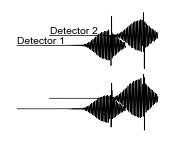

In [4]:


# which samples/observations from the test set to plot
top_sample_idx = 9
bot_sample_idx = 1

with mpl.rc_context(fname=mplrc):
    fig, ax = plt.subplots(2, 1, figsize=(2, 1.6))
    x_axis = np.linspace(0, 1, len(xs[top_sample_idx, 0].cpu().numpy()))
    _ = ax[0].plot(x_axis, xs[top_sample_idx, 0].cpu().numpy(), color="k", linewidth=0.5)
    _ = ax[0].plot(x_axis+0.3, xs[top_sample_idx, 1].cpu().numpy()+0.06, color="k", linewidth=0.5)
    _ = ax[bot_sample_idx].plot(x_axis, xs[bot_sample_idx, 0].cpu().numpy(), color="k", linewidth=0.5)
    _ = ax[bot_sample_idx].plot(x_axis+0.3, xs[bot_sample_idx, 1].cpu().numpy()+0.06, color="k", linewidth=0.5)
    _ = ax[0].text(0, 0.5, "Detector 1")
    _ = ax[0].text(0.3, 0.56, "Detector 2")
    for i in range(2):
        _ = ax[i].spines["left"].set_visible(False)
        _ = ax[i].spines["bottom"].set_visible(False)
        _ = ax[i].set_xticks([])
        _ = ax[i].set_yticks([])
    plt.subplots_adjust(hspace=0.0)
    plt.show()



### Custom Embedding Net

The observation for a given simulation consists of two very high-dimensional timeseries. It would be challenging to train a network conditioned directly on this high-dimensional observation, so instead we use an embedding network to learn lower-dimensional summary features of these timeseries. The embedding network can still be trained together with normalizing flow for NPE - so we do not need two separate training loops.

In [5]:
class PaperEmbedding(torch.nn.Sequential):
    def __init__(
        self,
        input_dim=(1, 2, 8192),
        nlayers=13,
        kernel_size=2,
        intermediate_channels=16,
        nfinal_channels=16
    ):
        """Reproducing https://github.com/montefiore-ai/trust-crisis-in-simulation-based-inference/blob/9dca4a508a19c514422a9b177d4fcf1dad6ea693/workflows/coverage_simulations_and_bias_reduction/gw/ratio_estimation.py#L129"""
        super(PaperEmbedding, self).__init__()
        self.add_module(
                f"conv1d::00-1x1",
                torch.nn.Conv1d(
                   input_dim[1], intermediate_channels, kernel_size=1
                ),
            )
        layer_idx = 1
        for i in range(nlayers):
            dilation = 2**i
            self.add_module(
                f"conv1d::{layer_idx:02.0f}-dil{dilation:02.0f}",
                torch.nn.Conv1d(
                    intermediate_channels, intermediate_channels, kernel_size=2, dilation=dilation
                ),
            )
            layer_idx += 1
            self.add_module(f"selu::{layer_idx:02.0f}", torch.nn.SELU())
            layer_idx += 1

        if intermediate_channels != nfinal_channels:
            self.add_module(
                f"conv1d::{layer_idx:02.0f}-1x1",
                torch.nn.Conv1d(
                    intermediate_channels, nfinal_channels, kernel_size=1
                ),
            )
        self.add_module(f"flatten::{layer_idx:02.0f}", torch.nn.Flatten())

    def forward(self, x):
        return super().forward(x)


def init_weights(m):
    if isinstance(m, torch.nn.Conv1d):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)



In [6]:

paper_net = PaperEmbedding(nlayers=13)
paper_net.apply(init_weights)

xs_ = xs.float().to(device)
thetas_ = thetas.to(device)
emnet = paper_net.to(device)

### Train the NPE model together with the embedding net

Alternatively, you can load a pre-trained model

In [7]:
# neural_posterior = neural_nets.posterior_nn(
#     model="nsf",
#     embedding_net=emnet,
#     device=str(device),
#     hidden_features=64,
#     num_transforms=3,
# )

# inference = SNPE(prior=prior, density_estimator=neural_posterior, device=str(device))
# density_estimator = inference.append_simulations(thetas_, xs_)
# learning_rate = 0.001
# nbatch = 128 if "cpu" in device.type else 2048
# max_num_epochs = 100

# density_estimator = density_estimator.train(
#     training_batch_size=nbatch,
#     show_train_summary=True,
#     learning_rate=learning_rate,
#     max_num_epochs=max_num_epochs,
# )



# Alternatively, load a pre-trained model

class Device_Unpickler(pickle.Unpickler):
    def __init__(self, target_device=None, **kwargs):
        super().__init__(**kwargs)
        self.target_device = target_device
        print(f"Unpickling to {target_device} device")

    def find_class(self, module, name):
        """see https://sbi.readthedocs.io/en/stable/how_to_guide/07_save_and_load.html"""
        if module == "torch.storage" and name == "_load_from_bytes":
            return lambda b: torch.load(io.BytesIO(b), map_location=self.target_device)
        else:
            return super().find_class(module, name)
figure_root = Path("./")
inputpath = figure_root / "results" / f"gws-nsf-npe-gpu.pkl"
assert inputpath.exists() and "gpu" in inputpath.name, f"unable to find {inputpath} or gpu not in input file name"
with open(inputpath, "rb") as f:
    posterior = Device_Unpickler(target_device=device, file=f).load()

if posterior._device != device:
    #Note that this is outdated. As of `sbi` v0.25.0, the posterior has a `to()` method.
    posterior._device = device

Unpickling to cpu device


/var/folders/4q/8fx0bbzx37x2pnkf3h36dsgm0000gn/T/ipykernel_50209/4005963337.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return lambda b: torch.load(io.BytesIO(b), m

In [8]:
# Sample from the ground truth of a particular observation
with h5py.File("data/gws-test.h5", "r") as in5:
    theta = torch.Tensor(np.asarray(in5["thetas"]))
    x = torch.Tensor(np.asarray(in5["xs"]))

idx = 1
theta_true = theta[idx: idx + 1, ...].cpu().numpy()
x_o = x[idx: idx + 1, ...].float().to(device)
samples = posterior.sample((1_000,), x=x_o).cpu().numpy()
x_o = x_o.cpu().numpy()



Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/Users/guymoss/miniconda3/envs/tutorial-paper/lib/python3.11/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2196.)
  outputs, _ = torch.triangular_solve(


### Visualize Posterior


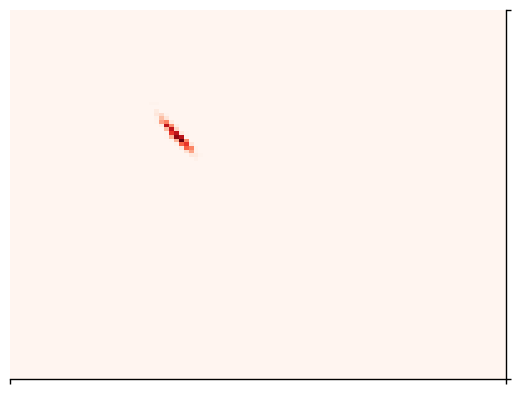

In [9]:
with mpl.rc_context(fname=mplrc):
    fig, ax = plt.subplots(1, 1)

    bins = 100
    range_ = [[40.0, 80.0], [0.25, 0.99]]
    counts, xedges, yedges = np.histogram2d(
        samples[:, 0], samples[:, 1], bins=bins, range=range_
    )

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(
        counts.T,
        extent=extent,
        origin='lower',
        aspect='auto',
        interpolation='none',
        cmap="Reds" #"viridis"  #cmap, #not sure where this variable was coming from
    )
#     sns.kdeplot(
#         x=samples[:10_000, 0],
#         y=samples[:10_000, 1],
#         thresh=0.0,
#         levels=100,
#         cmap=cmap,
#         ax=ax,
#     )
    _ = ax.yaxis.tick_right()

    _ = ax.spines["left"].set_visible(False)
    _ = ax.spines["right"].set_visible(True)
    _ = ax.set_xticks([40.0, 80.0])
    _ = ax.set_yticks([0.25, 0.99])
    _ = ax.set_xlim([40.0, 80.0])
    _ = ax.set_ylim([0.25, 0.99])
    _ = ax.set_xticklabels([])
    _ = ax.set_yticklabels([])

    plt.show()

### Amortized Posterior

Given a different observation, we can immediately sample from the posterior without retraining the network.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

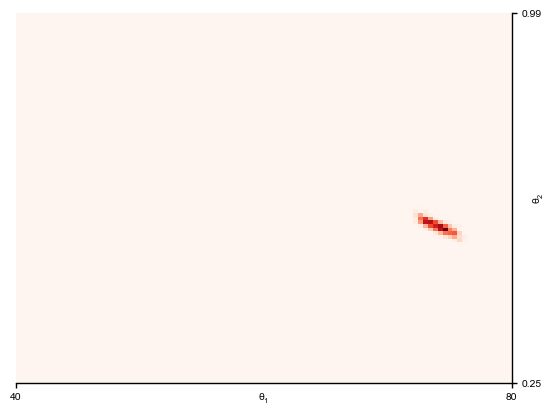

In [10]:
idx = 0
theta_true = theta[idx: idx + 1, ...].cpu().numpy()
x_o = x[idx: idx + 1, ...].float()
samples = posterior.sample((1_000,), x=x_o).cpu().numpy()

with mpl.rc_context(fname=mplrc):
    fig, ax = plt.subplots(1, 1)

    bins = 100
    range_ = [[40.0, 80.0], [0.25, 0.99]]
    counts, xedges, yedges = np.histogram2d(
        samples[:, 0], samples[:, 1], bins=bins, range=range_
    )

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(
        counts.T,
        extent=extent,
        origin='lower',
        aspect='auto',
        interpolation='none',
        cmap="Reds"
    )
#     sns.kdeplot(
#         x=samples[:10_000, 0],
#         y=samples[:10_000, 1],
#         fill=True,
#         thresh=0.05,
#         levels=5,
#         cmap="Reds",
#         ax=ax,
#     )

    _ = ax.spines["left"].set_visible(False)
    _ = ax.spines["right"].set_visible(True)
    _ = ax.set_xticks([40.0, 80.0])
    _ = ax.set_yticks([0.25, 0.99])
    _ = ax.set_xlim([40.0, 80.0])
    _ = ax.set_ylim([0.25, 0.99])
    _ = ax.set_xlabel(r"$\theta_1$", labelpad=-7)
    _ = ax.set_ylabel(r"$\theta_2$", labelpad=-7)
    _ = ax.yaxis.tick_right()
    _ = ax.yaxis.set_label_position("right")
    plt.show()


### Posterior Predictive

We can simulate from the posterior to verify whether posterior samples generate simulations that agree with the observation.

In [11]:
config_path = "data/config_file_pycbcmaster.ini"
pycbc_semver = pycbc.__version__.split(".")
if len(pycbc_semver) == 3 and pycbc_semver[0] == "2" and pycbc_semver[1] == "4":
    config_path = "data/config_file.ini"
simulator_obj = gws(str(config_path))

def simulator(theta_):
    """ theta[:,-1] is the ratio of mass2/mass1, so we have to multiply it with theta_[:,0] before feeding it into the simulator """
    theta = theta_.clone()
    theta[:, 1] = theta_[:, 1] * theta_[:, 0] #ratio*mass1
    xs = simulator_obj(theta.cpu()) #simulator doesn't support gpu execution
    return xs

def normalize_x(x, loc=0., scale=1.):
    return (x-loc)/scale


In [12]:


obs_sample_idx = top_sample_idx

# 3 posterior predictives. We visualize only one though.
samples = posterior.sample((50,), x=x[obs_sample_idx].float()).cpu().detach()

x_pp_raw = simulator(samples)
x_pp_raw = normalize_x(x_pp_raw, loc, scale)
pp_sample_idx = 42

Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

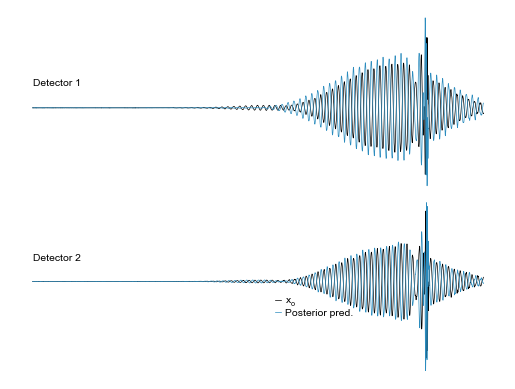

In [13]:
with mpl.rc_context(fname=mplrc):
    fig, ax = plt.subplots(2, 1)
    x_axis = np.linspace(0, 1, len(x[obs_sample_idx, 0].cpu().numpy()))
    _ = ax[0].plot(x_axis, x[obs_sample_idx, 0].cpu().numpy(), color="k", linewidth=0.5)
    _ = ax[0].plot(x_axis, x_pp_raw[pp_sample_idx, 0].cpu().numpy(), color="#2b8cbe", linewidth=0.5)
    _ = ax[1].plot(x_axis, x[obs_sample_idx, 1].cpu().numpy(), color="k", linewidth=0.5)
    _ = ax[1].plot(x_axis, x_pp_raw[pp_sample_idx, 1].cpu().numpy(), color="#2b8cbe", linewidth=0.5)
    _ = ax[0].text(0, 0.508, "Detector 1")
    _ = ax[1].text(0, 0.508, "Detector 2")
    _ = ax[1].legend(
        [r"$x_o$", "Posterior pred."], 
        loc="upper right",
        bbox_to_anchor=[0.71, 0.5, 0.0, 0.0],
        handletextpad=0.3,
        handlelength=0.6,
        labelspacing=-0.0,
    )
    for i in range(2):
        _ = ax[i].spines["left"].set_visible(False)
        _ = ax[i].spines["bottom"].set_visible(False)
        _ = ax[i].set_xticks([])
        _ = ax[i].set_yticks([])
    plt.subplots_adjust(hspace=0.0)
    plt.show()

### Simulation-based calibration

We can also perform simulation-based calibration checks to validate our learned
posteriors. As before, we need to generate a new set of simulations from our prior. 
Here, we show the simulation-based calibration in terms of the 1-dimensional marginal distributions, expected coverage of the posterior, and the Test of Accuracy with Random Points (TARP).

To do this, we generate a new dataset of samples from the joint distribution by sampling from the prior and simulating. We then compute the ranks of the true values of $\theta$ from the joint, compared to samples from the posterior for their respective observations $x$. To save time, we also provide the precomputed ranks.

In [14]:
num_sbc_samples = theta.shape[0]
num_posterior_samples = 1_000

#Compute SBC ranks for different measures.

# sbc_ranks, dap_samples = run_sbc(
#     theta, x, posterior, num_posterior_samples=num_posterior_samples
# )
# tarp_ranks, alphas = run_tarp(
#     theta.cpu(), x.cpu(), posterior=posterior, num_posterior_samples=num_posterior_samples
# )
# exp_cov_ranks,dap_samples = run_sbc(
#     theta.cpu(), x.cpu(), posterior, num_posterior_samples=num_posterior_samples,
#     reduce_fns=lambda th, xh: -posterior.log_prob(th, xh),
#     use_batched_sampling=True , # `True` can give speed-ups, but can cause memory issues. )
# )

#Alternatively, load precomputed ranks
with open("results/sbc_ranks.pkl", "rb") as handle:
    sbc_ranks, dap_samples = pickle.load(handle)

with open("results/tarp_ranks.pkl", "rb") as handle:
    tarp_ranks, alphas = pickle.load(handle)

with open("results/exp_cov_ranks.pkl", "rb") as handle:
    exp_cov_ranks, dap_samples = pickle.load(handle)

### Plot SBC rank plots

We visualize the ranks - we see that the distribution of ranks is close to uniform, indicating well-calibrated posteriors

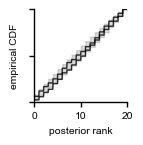

In [15]:
with mpl.rc_context(fname=mplrc):
    fig, ax = sbc_rank_plot(
        sbc_ranks,
        num_posterior_samples,
        num_bins=20,
        figsize=(1.2, 1.2),
        colors=["k", "k"],
    )
    _ = ax.legend([])
    plt.show()

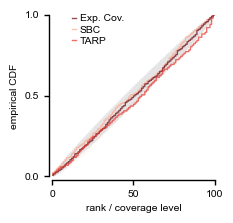

In [16]:
nbins = 100
histtype = "step"
repeats = 50
num_params = theta.shape[-1]
axis_setoff = -0.02

with mpl.rc_context(fname=mplrc):
    fig, ax = plt.subplots(1, 1, figsize=(2.1, 2.1))

    hb = binom(num_sbc_samples, p=1 / nbins).ppf(0.5) * np.ones(nbins)
    hbb = hb.cumsum() / hb.sum()
    hbb[-1] -= 1e-9
    lower = [binom(num_sbc_samples, p=p).ppf(0.005) for p in hbb]
    upper = [binom(num_sbc_samples, p=p).ppf(0.995) for p in hbb]

    ax.fill_between(
        x=np.linspace(0, nbins, repeats * nbins),
        y1=np.repeat(lower / np.max(lower), repeats),
        y2=np.repeat(upper / np.max(lower), repeats),
        color="grey",
        linewidth=0,
        alpha=0.2,
    )

    # Plot for marginal ranks
    alphas = np.linspace(0.1, 0.7, num_params)
    lines = []
    for jj in range(num_params):
        hist, *_ = np.histogram(sbc_ranks[:, jj].cpu().numpy(), bins=nbins, density=False)
        histcs = hist.cumsum()
        line = ax.plot(
            np.linspace(0, nbins, repeats * nbins),
            np.repeat(histcs / histcs.max(), repeats),
            label=f"SBC",
            color=colors["theta_shades"][0],
            alpha=alphas[jj],
        )
        lines.append(line[0])

    # Plot for EP and TARP
    hist, *_ = np.histogram(exp_cov_ranks.cpu().numpy(), bins=nbins, density=False)
    histcs = hist.cumsum()
    ep_line = ax.plot(
        np.linspace(0, nbins, repeats * nbins),
        np.repeat(histcs / histcs.max(), repeats),
        color=colors["theta_shades"][4],
        alpha=0.7,
        label="Exp. Cov.",
    )

    hist, *_ = np.histogram(tarp_ranks.cpu().numpy(), bins=nbins, density=False)
    histcs = hist.cumsum()
    tarp_line = ax.plot(
        np.linspace(0, nbins, repeats * nbins),
        np.repeat(histcs / histcs.max(), repeats),
        color=colors["theta_shades"][2],
        alpha=0.7,
        label="TARP",
    )

    # Set labels, ticks, and limits
    ax.set_yticks(np.linspace(0, 1, 3))
    ax.set_ylabel("empirical CDF")
    ax.set_ylim(0, 1)
    ax.set_xlim(0, nbins)
    ax.set_xticks(np.linspace(0, nbins, 3))
    ax.spines["left"].set_position(("axes", axis_setoff))
    ax.spines["bottom"].set_position(("axes", axis_setoff))
    ax.set_xlabel("rank / coverage level")

    legend2 = ax.legend(

        handles=[
                 ep_line[0], #ep plot axis
                 lines[-1],
                 tarp_line[0], #tarp plot axis
                 ],

        loc="lower right",
        bbox_to_anchor=(0.5, 0.75),
        handlelength=0.4,
        handletextpad=0.4,
        labelspacing=0.2,
        # title="EP and TARP",
    )

    plt.show();